# 1. Install necessary packages

In [1]:
!pip install torchsampler
!pip install torchmetrics
!pip install split-folders

#  2. Import required libraries

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix, classification_report
from torchsampler import ImbalancedDatasetSampler
from torch.utils.data.sampler import BatchSampler
import pandas as pd
import random
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, LeakyReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension

/tmp/ipykernel_124/1163429827.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /opt/conda/lib/python3.10/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    


# 3. Data Pre-processing

In [4]:
import splitfolders

# Split the dataset into train, test, and val folders
splitfolders.ratio('/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment', output="data1", seed=1337, ratio=(.7, 0.2, 0.1))

# Define the paths to train, test, and val folders
train_folder = "data1/train"
test_folder = "data1/test"
val_folder = "data1/val"


Copying files: 3076 files [00:04, 645.83 files/s]


**Data Augmentation**


train_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),

])

val_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(90),
                                       transforms.ToTensor(),

])

test_transforms = transforms.Compose([
                                       transforms.Resize((256,256)),
                                       transforms.ToTensor(),

])

In [5]:
from torchvision import transforms

# Training Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.RandomHorizontalFlip(),        # Random horizontal flipping
    transforms.RandomRotation(90),            # Random rotation
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])

# Validation Data Transforms
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])

# Test Data Transforms
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),            # Resizing to 256x256
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # Normalize for VGG16
])


# **4. Create data loaders**

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root = train_folder, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root = val_folder, transform=val_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_folder, transform=test_transforms)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), batch_size=16)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=16, shuffle=False)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# **5. Model definition**

In [9]:
model = models.vgg16(pretrained=True)
print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# **6. Modifying the Classifier**

In [10]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] =  nn.Linear(num_ftrs, 7)

# **7. Loss function and optimizer**

In [11]:

if torch.cuda.is_available() == True:
    model = model.cuda()
else:
    model = model
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler(enabled=True)
use_cuda = True

/tmp/ipykernel_124/235430509.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=True)


# **8. Training and testing functions**

In [12]:
train_accu = []
training_loss = []

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        with autocast():

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            scaler.scale(loss).backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    train_losss = epoch_loss / len(iterator)

    train_accu.append(score*100)
    training_loss.append(train_losss)

    #print(score)
    #print(len(train_accu), len(training_loss))

    return epoch_loss / len(iterator), epoch_acc / len(iterator), train_accu, training_loss

In [13]:
val_accu = []
eval_loss = []

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    image_preds_all = []
    image_targets_all = []

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device).float()
            y = y.to(device).long()

            y_pred = model(x)

            image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
            image_targets_all += [y.detach().cpu().numpy()]

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    score = (image_preds_all==image_targets_all).mean()

    val_losss = epoch_loss / len(iterator)

    val_accu.append(score*100)
    eval_loss.append(val_losss)

    performance_matrix(image_targets_all, image_preds_all)

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_accu, eval_loss

In [14]:
def performance_matrix(true,pred):
    precision = precision_score(true,pred,average='macro')
    recall = recall_score(true,pred,average='macro')
    accuracy = accuracy_score(true,pred)
    f1_sco = f1_score(true,pred,average='macro')
    print('Precision: {:.4f} Recall: {:.4f}, Accuracy: {:.4f}: ,f1_score: {:.4f}'.format(precision,recall,accuracy,f1_sco))
    print('Classification Report:\n',classification_report(true, pred))

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [17]:
def checkpoint_model(epoch, model, opt, best_val_acc, model_path):
    model_state_dict = model.state_dict() if (device.type == 'cuda') else model.state_dict()
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_state_dict,
        'opt_state_dict': opt.state_dict(),
        'best_val_acc': best_val_acc
    }, model_path)

In [18]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['opt_state_dict'])
    return model, optimizer, checkpoint['epoch']

# **9. Training and validating the model**

EPOCHS = 50

best_valid_loss = float('inf')
best_val_acc = 0.

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model, val_loader, criterion, device)

    if epoch % 30 == 0:
        checkpoint_model(epoch, model, optimizer, best_val_acc, '/kaggle/working/CNN_epoch%d.pth' % epoch)


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


plt.plot(train_acc_gr,'-o')
plt.plot(val_acc_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr,'-o')
plt.plot(val_loss_gr,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

The model has 134,289,223 trainable parameters


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Precision: 0.5323 Recall: 0.5983, Accuracy: 0.5049: ,f1_score: 0.5105
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       113
           1       0.83      0.30      0.44       149
           2       0.26      0.82      0.39        40
           3       0.48      0.85      0.61        13
           4       0.40      0.39      0.39       122
           5       0.45      0.71      0.55        69
           6       0.53      0.32      0.40       106

    accuracy                           0.50       612
   macro avg       0.53      0.60      0.51       612
weighted avg       0.60      0.50      0.50       612



Epochs:   5%|▌         | 1/20 [01:17<24:24, 77.08s/it]

Epoch: 01 | Epoch Time: 1m 17s
	Train Loss: 1.449 | Train Acc: 45.48%
	 Val. Loss: 1.277 |  Val. Acc: 50.00%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  10%|█         | 2/20 [02:33<23:04, 76.94s/it]

Precision: 0.6176 Recall: 0.5996, Accuracy: 0.5490: ,f1_score: 0.5677
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.79       113
           1       0.86      0.29      0.43       149
           2       0.45      0.75      0.57        40
           3       0.62      0.77      0.69        13
           4       0.37      0.68      0.48       122
           5       0.76      0.46      0.58        69
           6       0.53      0.39      0.45       106

    accuracy                           0.55       612
   macro avg       0.62      0.60      0.57       612
weighted avg       0.64      0.55      0.54       612

Epoch: 02 | Epoch Time: 1m 16s
	Train Loss: 1.210 | Train Acc: 55.43%
	 Val. Loss: 1.173 |  Val. Acc: 54.33%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  15%|█▌        | 3/20 [03:49<21:40, 76.50s/it]

Precision: 0.5957 Recall: 0.6214, Accuracy: 0.5866: ,f1_score: 0.5896
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.81       113
           1       0.78      0.39      0.52       149
           2       0.43      0.70      0.53        40
           3       0.56      0.69      0.62        13
           4       0.43      0.63      0.51       122
           5       0.61      0.65      0.63        69
           6       0.57      0.45      0.51       106

    accuracy                           0.59       612
   macro avg       0.60      0.62      0.59       612
weighted avg       0.63      0.59      0.58       612

Epoch: 03 | Epoch Time: 1m 15s
	Train Loss: 1.175 | Train Acc: 56.91%
	 Val. Loss: 1.087 |  Val. Acc: 58.01%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  20%|██        | 4/20 [05:05<20:19, 76.25s/it]

Precision: 0.6004 Recall: 0.6046, Accuracy: 0.5294: ,f1_score: 0.5406
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       113
           1       0.89      0.22      0.35       149
           2       0.47      0.72      0.57        40
           3       0.58      0.85      0.69        13
           4       0.37      0.75      0.49       122
           5       0.49      0.68      0.57        69
           6       0.61      0.21      0.31       106

    accuracy                           0.53       612
   macro avg       0.60      0.60      0.54       612
weighted avg       0.64      0.53      0.50       612

Epoch: 04 | Epoch Time: 1m 15s
	Train Loss: 1.171 | Train Acc: 56.91%
	 Val. Loss: 1.220 |  Val. Acc: 51.92%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  25%|██▌       | 5/20 [06:21<19:02, 76.17s/it]

Precision: 0.5685 Recall: 0.6292, Accuracy: 0.5474: ,f1_score: 0.5471
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.88      0.74       113
           1       0.88      0.30      0.45       149
           2       0.33      0.88      0.48        40
           3       0.53      0.77      0.62        13
           4       0.46      0.45      0.45       122
           5       0.56      0.78      0.65        69
           6       0.59      0.34      0.43       106

    accuracy                           0.55       612
   macro avg       0.57      0.63      0.55       612
weighted avg       0.62      0.55      0.53       612

Epoch: 05 | Epoch Time: 1m 16s
	Train Loss: 1.140 | Train Acc: 57.86%
	 Val. Loss: 1.202 |  Val. Acc: 54.17%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  30%|███       | 6/20 [07:37<17:41, 75.84s/it]

Precision: 0.5982 Recall: 0.6517, Accuracy: 0.5899: ,f1_score: 0.5979
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.88      0.78       113
           1       0.77      0.42      0.55       149
           2       0.46      0.78      0.57        40
           3       0.61      0.85      0.71        13
           4       0.45      0.61      0.52       122
           5       0.60      0.72      0.66        69
           6       0.60      0.30      0.40       106

    accuracy                           0.59       612
   macro avg       0.60      0.65      0.60       612
weighted avg       0.62      0.59      0.58       612

Epoch: 06 | Epoch Time: 1m 15s
	Train Loss: 1.149 | Train Acc: 57.17%
	 Val. Loss: 1.104 |  Val. Acc: 57.85%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  35%|███▌      | 7/20 [08:52<16:24, 75.75s/it]

Precision: 0.5682 Recall: 0.6197, Accuracy: 0.5654: ,f1_score: 0.5693
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81       113
           1       0.70      0.48      0.57       149
           2       0.42      0.68      0.52        40
           3       0.59      0.77      0.67        13
           4       0.57      0.29      0.38       122
           5       0.40      0.77      0.52        69
           6       0.48      0.57      0.52       106

    accuracy                           0.57       612
   macro avg       0.57      0.62      0.57       612
weighted avg       0.60      0.57      0.56       612

Epoch: 07 | Epoch Time: 1m 15s
	Train Loss: 1.156 | Train Acc: 56.74%
	 Val. Loss: 1.072 |  Val. Acc: 55.93%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  40%|████      | 8/20 [10:07<15:07, 75.63s/it]

Precision: 0.5816 Recall: 0.6391, Accuracy: 0.5735: ,f1_score: 0.5786
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80       113
           1       0.79      0.39      0.52       149
           2       0.34      0.88      0.49        40
           3       0.56      0.77      0.65        13
           4       0.46      0.52      0.49       122
           5       0.57      0.67      0.61        69
           6       0.57      0.43      0.49       106

    accuracy                           0.57       612
   macro avg       0.58      0.64      0.58       612
weighted avg       0.63      0.57      0.57       612

Epoch: 08 | Epoch Time: 1m 15s
	Train Loss: 1.109 | Train Acc: 57.91%
	 Val. Loss: 1.117 |  Val. Acc: 56.73%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  45%|████▌     | 9/20 [11:23<13:52, 75.66s/it]

Precision: 0.5768 Recall: 0.6392, Accuracy: 0.5654: ,f1_score: 0.5727
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.65      0.76       113
           1       0.63      0.59      0.61       149
           2       0.40      0.72      0.51        40
           3       0.60      0.92      0.73        13
           4       0.58      0.20      0.30       122
           5       0.42      0.75      0.54        69
           6       0.51      0.62      0.56       106

    accuracy                           0.57       612
   macro avg       0.58      0.64      0.57       612
weighted avg       0.61      0.57      0.56       612

Epoch: 09 | Epoch Time: 1m 15s
	Train Loss: 1.132 | Train Acc: 60.08%
	 Val. Loss: 1.128 |  Val. Acc: 55.93%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  50%|█████     | 10/20 [12:39<12:37, 75.76s/it]

Precision: 0.5636 Recall: 0.6299, Accuracy: 0.5458: ,f1_score: 0.5555
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.77      0.81       113
           1       0.69      0.49      0.57       149
           2       0.33      0.85      0.48        40
           3       0.61      0.85      0.71        13
           4       0.55      0.25      0.34       122
           5       0.37      0.78      0.50        69
           6       0.54      0.42      0.47       106

    accuracy                           0.55       612
   macro avg       0.56      0.63      0.56       612
weighted avg       0.60      0.55      0.54       612

Epoch: 10 | Epoch Time: 1m 15s
	Train Loss: 1.123 | Train Acc: 58.59%
	 Val. Loss: 1.153 |  Val. Acc: 54.01%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  55%|█████▌    | 11/20 [13:55<11:21, 75.74s/it]

Precision: 0.6262 Recall: 0.6465, Accuracy: 0.5850: ,f1_score: 0.6124
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.65      0.75       113
           1       0.67      0.51      0.58       149
           2       0.51      0.78      0.61        40
           3       0.69      0.85      0.76        13
           4       0.61      0.33      0.43       122
           5       0.59      0.64      0.62        69
           6       0.41      0.78      0.54       106

    accuracy                           0.58       612
   macro avg       0.63      0.65      0.61       612
weighted avg       0.64      0.58      0.58       612

Epoch: 11 | Epoch Time: 1m 15s
	Train Loss: 1.162 | Train Acc: 58.80%
	 Val. Loss: 1.064 |  Val. Acc: 59.29%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  60%|██████    | 12/20 [15:10<10:05, 75.63s/it]

Precision: 0.5679 Recall: 0.6365, Accuracy: 0.5605: ,f1_score: 0.5532
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.81       113
           1       0.67      0.55      0.60       149
           2       0.31      0.88      0.46        40
           3       0.61      0.85      0.71        13
           4       0.61      0.11      0.19       122
           5       0.48      0.65      0.56        69
           6       0.50      0.58      0.54       106

    accuracy                           0.56       612
   macro avg       0.57      0.64      0.55       612
weighted avg       0.60      0.56      0.54       612

Epoch: 12 | Epoch Time: 1m 15s
	Train Loss: 1.147 | Train Acc: 59.47%
	 Val. Loss: 1.123 |  Val. Acc: 55.45%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  65%|██████▌   | 13/20 [16:26<08:48, 75.57s/it]

Precision: 0.5763 Recall: 0.6387, Accuracy: 0.5637: ,f1_score: 0.5664
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       113
           1       0.66      0.56      0.61       149
           2       0.37      0.82      0.51        40
           3       0.61      0.85      0.71        13
           4       0.66      0.20      0.31       122
           5       0.40      0.77      0.53        69
           6       0.50      0.49      0.50       106

    accuracy                           0.56       612
   macro avg       0.58      0.64      0.57       612
weighted avg       0.62      0.56      0.55       612

Epoch: 13 | Epoch Time: 1m 15s
	Train Loss: 1.165 | Train Acc: 59.01%
	 Val. Loss: 1.089 |  Val. Acc: 55.77%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  70%|███████   | 14/20 [17:41<07:32, 75.47s/it]

Precision: 0.5897 Recall: 0.6538, Accuracy: 0.5833: ,f1_score: 0.5813
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       113
           1       0.68      0.59      0.63       149
           2       0.34      0.93      0.50        40
           3       0.61      0.85      0.71        13
           4       0.60      0.34      0.44       122
           5       0.43      0.68      0.53        69
           6       0.69      0.34      0.46       106

    accuracy                           0.58       612
   macro avg       0.59      0.65      0.58       612
weighted avg       0.63      0.58      0.58       612

Epoch: 14 | Epoch Time: 1m 15s
	Train Loss: 1.150 | Train Acc: 58.22%
	 Val. Loss: 1.112 |  Val. Acc: 57.21%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  75%|███████▌  | 15/20 [18:57<06:18, 75.68s/it]

Precision: 0.5612 Recall: 0.5857, Accuracy: 0.5212: ,f1_score: 0.5156
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.80       113
           1       0.79      0.44      0.56       149
           2       0.29      0.93      0.45        40
           3       0.62      0.62      0.62        13
           4       0.54      0.30      0.38       122
           5       0.33      0.72      0.45        69
           6       0.60      0.25      0.35       106

    accuracy                           0.52       612
   macro avg       0.56      0.59      0.52       612
weighted avg       0.61      0.52      0.52       612

Epoch: 15 | Epoch Time: 1m 16s
	Train Loss: 1.105 | Train Acc: 60.39%
	 Val. Loss: 1.215 |  Val. Acc: 51.12%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  80%|████████  | 16/20 [20:12<05:02, 75.54s/it]

Precision: 0.5965 Recall: 0.6336, Accuracy: 0.5376: ,f1_score: 0.5350
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.73      0.78       113
           1       0.75      0.47      0.58       149
           2       0.32      0.85      0.47        40
           3       0.60      0.92      0.73        13
           4       0.82      0.07      0.14       122
           5       0.43      0.70      0.53        69
           6       0.43      0.69      0.53       106

    accuracy                           0.54       612
   macro avg       0.60      0.63      0.53       612
weighted avg       0.65      0.54      0.51       612

Epoch: 16 | Epoch Time: 1m 15s
	Train Loss: 1.144 | Train Acc: 60.13%
	 Val. Loss: 1.215 |  Val. Acc: 53.21%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  85%|████████▌ | 17/20 [21:28<03:46, 75.60s/it]

Precision: 0.5943 Recall: 0.6602, Accuracy: 0.5752: ,f1_score: 0.5905
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.83       113
           1       0.75      0.41      0.53       149
           2       0.39      0.88      0.54        40
           3       0.63      0.92      0.75        13
           4       0.44      0.53      0.48       122
           5       0.45      0.71      0.55        69
           6       0.66      0.33      0.44       106

    accuracy                           0.58       612
   macro avg       0.59      0.66      0.59       612
weighted avg       0.63      0.58      0.57       612

Epoch: 17 | Epoch Time: 1m 15s
	Train Loss: 1.105 | Train Acc: 60.34%
	 Val. Loss: 1.113 |  Val. Acc: 56.41%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  90%|█████████ | 18/20 [22:44<02:31, 75.80s/it]

Precision: 0.6055 Recall: 0.6822, Accuracy: 0.6095: ,f1_score: 0.6198
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.76      0.81       113
           1       0.64      0.60      0.62       149
           2       0.38      0.93      0.54        40
           3       0.60      0.92      0.73        13
           4       0.54      0.44      0.49       122
           5       0.61      0.67      0.63        69
           6       0.60      0.45      0.52       106

    accuracy                           0.61       612
   macro avg       0.61      0.68      0.62       612
weighted avg       0.63      0.61      0.61       612

Epoch: 18 | Epoch Time: 1m 16s
	Train Loss: 1.082 | Train Acc: 61.71%
	 Val. Loss: 1.009 |  Val. Acc: 59.78%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs:  95%|█████████▌| 19/20 [24:00<01:15, 75.65s/it]

Precision: 0.6171 Recall: 0.6789, Accuracy: 0.6029: ,f1_score: 0.6149
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       113
           1       0.71      0.48      0.58       149
           2       0.46      0.82      0.59        40
           3       0.60      0.92      0.73        13
           4       0.72      0.32      0.44       122
           5       0.53      0.70      0.60        69
           6       0.46      0.74      0.56       106

    accuracy                           0.60       612
   macro avg       0.62      0.68      0.61       612
weighted avg       0.65      0.60      0.60       612

Epoch: 19 | Epoch Time: 1m 15s
	Train Loss: 1.074 | Train Acc: 61.69%
	 Val. Loss: 1.014 |  Val. Acc: 59.62%


Training:   0%|          | 0/135 [00:00<?, ?it/s]

/tmp/ipykernel_124/3724402198.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epochs: 100%|██████████| 20/20 [25:16<00:00, 75.81s/it]

Precision: 0.6078 Recall: 0.6859, Accuracy: 0.6111: ,f1_score: 0.6175
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       113
           1       0.64      0.55      0.59       149
           2       0.37      0.93      0.53        40
           3       0.57      0.92      0.71        13
           4       0.54      0.48      0.51       122
           5       0.61      0.68      0.64        69
           6       0.71      0.42      0.52       106

    accuracy                           0.61       612
   macro avg       0.61      0.69      0.62       612
weighted avg       0.64      0.61      0.61       612

Epoch: 20 | Epoch Time: 1m 16s
	Train Loss: 1.029 | Train Acc: 62.75%
	 Val. Loss: 1.027 |  Val. Acc: 59.94%


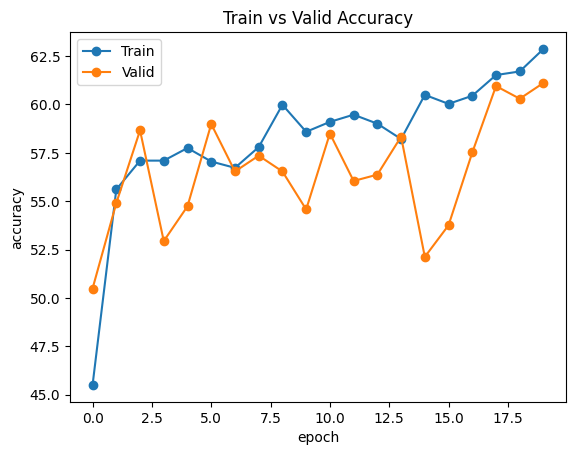

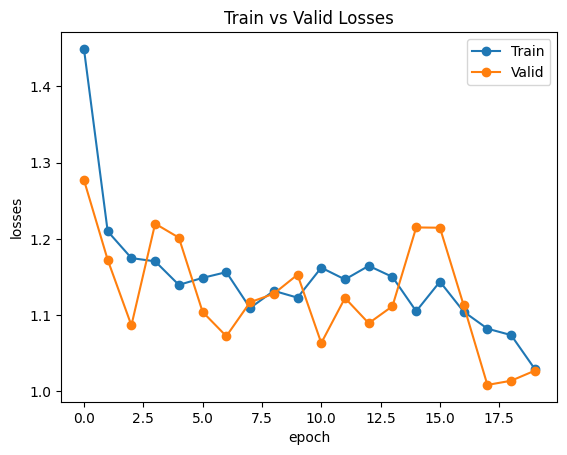

In [19]:
import os
import time
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import trange

EPOCHS = 20
PATIENCE = 10  # Number of epochs to wait before early stopping
BATCH_SIZE = 16
best_valid_loss = float('inf')
best_val_acc = 0.
epochs_no_improve = 0  # Counter for early stopping

# 1. **Count Parameters in AlexNet**
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

train_acc_gr = []
train_loss_gr = []
val_acc_gr = []
val_loss_gr = []

# 2. **Optimizing Learning Rate and Weight Decay**
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# 3. **Learning Rate Scheduler**
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# 4. **Fine-Tune Selected Layers (if using a pretrained AlexNet)**
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers initially

# Unfreeze specific layers for fine-tuning
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Training Loop with Early Stopping
for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()

    # 5. **Training Step**
    train_loss, train_acc, train_acc_gr, train_loss_gr = train(model, train_loader, optimizer, criterion, device)
    
    # 6. **Validation Step**
    valid_loss, valid_acc, val_acc_gr, val_loss_gr = evaluate(model, val_loader, criterion, device)
    
    # Update scheduler based on validation loss
    scheduler.step(valid_loss)

    # Check for improvement
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_val_acc = valid_acc
        epochs_no_improve = 0  # Reset counter if validation improves
    else:
        epochs_no_improve += 1

    # Early stopping check
    if epochs_no_improve >= PATIENCE:
        print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss/accuracy.')
        break

    # Save model checkpoint every 30 epochs
    if epoch % 30 == 0:
        checkpoint_model(epoch, model, optimizer, best_val_acc, '/kaggle/working/CNN_epoch%d.pth' % epoch)

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print metrics for each epoch
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

# Plot training and validation accuracy and loss
plt.plot(train_acc_gr, '-o')
plt.plot(val_acc_gr, '-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

plt.plot(train_loss_gr, '-o')
plt.plot(val_loss_gr, '-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train', 'Valid'])
plt.title('Train vs Valid Losses')
plt.show()


# **10. Testing the model**

In [20]:
epoch_loss = 0
epoch_acc = 0
image_preds_all = []
image_targets_all = []

model.eval()

with torch.no_grad():

    for (x, y) in tqdm(val_loader, desc="Evaluating", leave=False):

        x = x.to(device).float()
        y = y.to(device).long()

        y_pred = model(x)

        image_preds_all += [torch.argmax(y_pred, 1).detach().cpu().numpy()]
        image_targets_all += [y.detach().cpu().numpy()]

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

image_preds_all = np.concatenate(image_preds_all)
image_targets_all = np.concatenate(image_targets_all)
score = (image_preds_all==image_targets_all).mean()

performance_matrix(image_targets_all, image_preds_all)

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Precision: 0.6078 Recall: 0.6859, Accuracy: 0.6111: ,f1_score: 0.6175
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       113
           1       0.64      0.55      0.59       149
           2       0.37      0.93      0.53        40
           3       0.57      0.92      0.71        13
           4       0.54      0.48      0.51       122
           5       0.61      0.68      0.64        69
           6       0.71      0.42      0.52       106

    accuracy                           0.61       612
   macro avg       0.61      0.69      0.62       612
weighted avg       0.64      0.61      0.61       612



In [28]:
from PIL import Image

def predict_image(image_path, model, transform, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply the same transformations as used during training
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the device (GPU/CPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Make prediction without calculating gradients
    with torch.no_grad():
        # Get the model's output
        output = model(image)

        # Get the predicted class
        _, predicted_class = torch.max(output, 1)

    # Return the predicted class
    return predicted_class.item()

# Example usage:
image_path = '/kaggle/input/potato-leaf-disease-dataset/Potato Leaf Disease Dataset in Uncontrolled Environment/Fungi/1692332350583.jpg'  # Replace with the path to the image you want to predict
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

predicted_class = predict_image(image_path, model, transform, device)
if predicted_class==0:
    print(f'The predicted class for the given image is: bacteria')
elif predicted_class==1:
    print(f'The predicted class for the given image is: fungi')
elif predicted_class==2:
    print(f'The predicted class for the given image is: healthy')
elif predicted_class==3:
    print(f'The predicted class for the given image is: Nemastode')
elif predicted_class==4:
    print(f'The predicted class for the given image is: k')
elif predicted_class==5:
    print(f'The predicted class for the given image is: Phytopthora')
elif predicted_class==6:
    print(f'The predicted class for the given image is: Virus')


The predicted class for the given image is: Phytopthora
